In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import shutil, os
import matplotlib.pyplot as plt
import torch
import yaml

from os import listdir
from os.path import isfile, join
from glob import glob
from sklearn.model_selection import GroupKFold
from tqdm.notebook import tqdm
from pathlib import Path

In [2]:
!pip install ultralytics --quiet
!pip install -U ipywidgets --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.22.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.10.0, but you have google-cloud-bigquery 2.34.4 which is incompatible.
bigframes 0.22.0 requires google-cloud-storage>=2.0.0, but you have google-cloud-storage 1.44.0 which is incompatible.
bigframes 0.22.0 requires pandas<2.1.4,>=1.5.0, but you have pandas 2.2.2 which is incompatible.
dataproc-jupyter-plugin 0.1.79 requires pydantic~=1.10.0, but you have pydantic 2.8.2 which is incompatible.


In [12]:
class CFG:
    CLASS_NAMES = [
        "Aortic enlargement",
        "Atelectasis",
        "Calcification",
        "Cardiomegaly",
        "Consolidation",
        "ILD",
        "Infiltration",
        "Lung Opacity",
        "Nodule/Mass",
        "Other lesion",
        "Pleural effusion",
        "Pleural thickening",
        "Pneumothorax",
        "Pulmonary fibrosis"
    ]
    
    BEST_MODEL_PATH = "models/best_model.pt"
    TRAIN_IMAGE_PATH = '/kaggle/input/vinbigdata-512-image-dataset/vinbigdata/train.csv'
    TRAIN_TXT_PATH = '/kaggle/working/train.txt'
    VAL_IMAGE_PATH = '/kaggle/input/vinai5000records/yolo_data/val'
    VAL_TXT_PATH = '/kaggle/working/val.txt'
    TEST_DIR = '/kaggle/input/vinbigdata-512-image-dataset/vinbigdata/test.csv'
    WEIGHTS_DIR = '/kaggle/input/vinbigdata-cxr-ad-yolov5-14-class-train/yolov5/runs/train/exp/weights/best.pt'
    YOLOV5_YAML = '/kaggle/working/yolov5.yaml'
    YOLOV8_YAML = '/kaggle/working/yolov8.yaml'
    
    WB_PROJECT_NAME = 'VinDr-CXR'
    
    EPOCHS = 30
    BATCH_SIZE = 64
    
    DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    
    COLOR_MODE = 'rgb'
    INPUT_SIZE = 640
    INTERVAL = 10
    DIM = 512

In [4]:
train_df = pd.read_csv(CFG.TRAIN_IMAGE_PATH)
train_df.tail()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height
67909,936fd5cff1c058d39817a08f58b72cae,No finding,14,R1,NaN,NaN,NaN,NaN,2444,3200
67910,ca7e72954550eeb610fe22bf0244b7fa,No finding,14,R1,NaN,NaN,NaN,NaN,1994,2430
67911,aa17d5312a0fb4a2939436abca7f9579,No finding,14,R8,NaN,NaN,NaN,NaN,2048,2500
67912,4b56bc6d22b192f075f13231419dfcc8,Cardiomegaly,3,R8,771.0,979.0,1680.0,1311.0,1968,2040
67913,5e272e3adbdaafb07a7e84a9e62b1a4c,No finding,14,R16,NaN,NaN,NaN,NaN,2048,2500


In [5]:
train_df['image_path'] = f'/kaggle/input/vinbigdata-{CFG.DIM}-image-dataset/vinbigdata/train/'+train_df.image_id+('.png' if CFG.DIM!='original' else '.jpg')
train_df.tail()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height,image_path
67909,936fd5cff1c058d39817a08f58b72cae,No finding,14,R1,NaN,NaN,NaN,NaN,2444,3200,/kaggle/input/vinbigdata-512-image-dataset/vin...
67910,ca7e72954550eeb610fe22bf0244b7fa,No finding,14,R1,NaN,NaN,NaN,NaN,1994,2430,/kaggle/input/vinbigdata-512-image-dataset/vin...
67911,aa17d5312a0fb4a2939436abca7f9579,No finding,14,R8,NaN,NaN,NaN,NaN,2048,2500,/kaggle/input/vinbigdata-512-image-dataset/vin...
67912,4b56bc6d22b192f075f13231419dfcc8,Cardiomegaly,3,R8,771.0,979.0,1680.0,1311.0,1968,2040,/kaggle/input/vinbigdata-512-image-dataset/vin...
67913,5e272e3adbdaafb07a7e84a9e62b1a4c,No finding,14,R16,NaN,NaN,NaN,NaN,2048,2500,/kaggle/input/vinbigdata-512-image-dataset/vin...


# Annotate Bounding box

In [6]:
train_df['x_min'] = train_df.apply(lambda row: (row.x_min)/row.width, axis =1)
train_df['y_min'] = train_df.apply(lambda row: (row.y_min)/row.height, axis =1)

train_df['x_max'] = train_df.apply(lambda row: (row.x_max)/row.width, axis =1)
train_df['y_max'] = train_df.apply(lambda row: (row.y_max)/row.height, axis =1)

train_df['x_mid'] = train_df.apply(lambda row: (row.x_max+row.x_min)/2, axis =1)
train_df['y_mid'] = train_df.apply(lambda row: (row.y_max+row.y_min)/2, axis =1)

train_df['w'] = train_df.apply(lambda row: (row.x_max-row.x_min), axis =1)
train_df['h'] = train_df.apply(lambda row: (row.y_max-row.y_min), axis =1)

train_df['area'] = train_df['w']*train_df['h']
train_df.tail()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height,image_path,x_mid,y_mid,w,h,area
67909,936fd5cff1c058d39817a08f58b72cae,No finding,14,R1,NaN,NaN,NaN,NaN,2444,3200,/kaggle/input/vinbigdata-512-image-dataset/vin...,NaN,NaN,NaN,NaN,NaN
67910,ca7e72954550eeb610fe22bf0244b7fa,No finding,14,R1,NaN,NaN,NaN,NaN,1994,2430,/kaggle/input/vinbigdata-512-image-dataset/vin...,NaN,NaN,NaN,NaN,NaN
67911,aa17d5312a0fb4a2939436abca7f9579,No finding,14,R8,NaN,NaN,NaN,NaN,2048,2500,/kaggle/input/vinbigdata-512-image-dataset/vin...,NaN,NaN,NaN,NaN,NaN
67912,4b56bc6d22b192f075f13231419dfcc8,Cardiomegaly,3,R8,0.391768,0.479902,0.853659,0.642647,1968,2040,/kaggle/input/vinbigdata-512-image-dataset/vin...,0.622713,0.561275,0.46189,0.162745,0.07517
67913,5e272e3adbdaafb07a7e84a9e62b1a4c,No finding,14,R16,NaN,NaN,NaN,NaN,2048,2500,/kaggle/input/vinbigdata-512-image-dataset/vin...,NaN,NaN,NaN,NaN,NaN


In [7]:
features = ['x_min', 'y_min', 'x_max', 'y_max', 'x_mid', 'y_mid', 'w', 'h', 'area']
X = train_df[features]
y = train_df['class_id']
X.shape, y.shape

((67914, 9), (67914,))

In [8]:
class_ids, class_names = list(zip(*set(zip(train_df.class_id, train_df.class_name))))
classes = list(np.array(class_names)[np.argsort(class_ids)])
classes = list(map(lambda x: str(x), classes))
classes

['Aortic enlargement',
 'Atelectasis',
 'Calcification',
 'Cardiomegaly',
 'Consolidation',
 'ILD',
 'Infiltration',
 'Lung Opacity',
 'Nodule/Mass',
 'Other lesion',
 'Pleural effusion',
 'Pleural thickening',
 'Pneumothorax',
 'Pulmonary fibrosis',
 'No finding']

# Split data

In [9]:
gkf  = GroupKFold(n_splits = 5)
train_df['fold'] = -1
for fold, (train_idx, val_idx) in enumerate(gkf.split(train_df, groups = train_df.image_id.tolist())):
    train_df.loc[val_idx, 'fold'] = fold
train_df.tail()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height,image_path,x_mid,y_mid,w,h,area,fold
67909,936fd5cff1c058d39817a08f58b72cae,No finding,14,R1,NaN,NaN,NaN,NaN,2444,3200,/kaggle/input/vinbigdata-512-image-dataset/vin...,NaN,NaN,NaN,NaN,NaN,3
67910,ca7e72954550eeb610fe22bf0244b7fa,No finding,14,R1,NaN,NaN,NaN,NaN,1994,2430,/kaggle/input/vinbigdata-512-image-dataset/vin...,NaN,NaN,NaN,NaN,NaN,1
67911,aa17d5312a0fb4a2939436abca7f9579,No finding,14,R8,NaN,NaN,NaN,NaN,2048,2500,/kaggle/input/vinbigdata-512-image-dataset/vin...,NaN,NaN,NaN,NaN,NaN,1
67912,4b56bc6d22b192f075f13231419dfcc8,Cardiomegaly,3,R8,0.391768,0.479902,0.853659,0.642647,1968,2040,/kaggle/input/vinbigdata-512-image-dataset/vin...,0.622713,0.561275,0.46189,0.162745,0.07517,3
67913,5e272e3adbdaafb07a7e84a9e62b1a4c,No finding,14,R16,NaN,NaN,NaN,NaN,2048,2500,/kaggle/input/vinbigdata-512-image-dataset/vin...,NaN,NaN,NaN,NaN,NaN,2


In [14]:
train_files = []
val_files   = []
val_files += list(train_df[train_df.fold==fold].image_path.unique())
train_files += list(train_df[train_df.fold!=fold].image_path.unique())
len(train_files), len(val_files)

(12000, 3000)

In [ ]:
os.makedirs('/kaggle/working/vinbigdata/labels/train', exist_ok = True)
os.makedirs('/kaggle/working/vinbigdata/labels/val', exist_ok = True)
os.makedirs('/kaggle/working/vinbigdata/images/train', exist_ok = True)
os.makedirs('/kaggle/working/vinbigdata/images/val', exist_ok = True)
label_dir = '/kaggle/input/vinbigdata-yolo-labels-dataset/labels'
for file in tqdm(train_files):
    shutil.copy(file, '/kaggle/working/vinbigdata/images/train')
    filename = file.split('/')[-1].split('.')[0]
    shutil.copy(os.path.join(label_dir, filename+'.txt'), '/kaggle/working/vinbigdata/labels/train')
    
for file in tqdm(val_files):
    shutil.copy(file, '/kaggle/working/vinbigdata/images/val')
    filename = file.split('/')[-1].split('.')[0]
    shutil.copy(os.path.join(label_dir, filename+'.txt'), '/kaggle/working/vinbigdata/labels/val')


In [ ]:
with open(CFG.TRAIN_TXT_PATH, 'w') as f:
    for path in glob('/kaggle/working/vinbigdata/images/train/*'):
        f.write(path+'\n')
            
with open(CFG.VAL_TXT_PATH, 'w') as f:
    for path in glob('/kaggle/working/vinbigdata/images/val/*'):
        f.write(path+'\n')

In [ ]:
yaml_content = f"""
train: {CFG.TRAIN_TXT_PATH}
val: {CFG.VAL_IMAGE_PATH}

nc: {len(CFG.CLASS_NAMES)}
names:
""" + '\n'.join([f"- {name}" for name in CFG.CLASS_NAMES])

with open(CFG.YOLOV5_YAML, 'w') as yaml_file:
    yaml_file.write(yaml_content)

In [ ]:
print(open(CFG.YOLOV5_YAML, 'r').read())

In [ ]:
from ultralytics import YOLO
model = YOLO("yolov5n.pt") 

In [ ]:
results = model.train(data=CFG.YOLOV5_YAML, epochs=CFG.EPOCHS, imgsz=CFG.INPUT_SIZE, project=CFG.WB_PROJECT_NAME)

In [ ]:
test_modelv5 = YOLO("/kaggle/working/VinDr-CXR/train2/weights/best.pt")

In [ ]:
results = test_modelv5(["/kaggle/input/testmodeltrandich/trandich.jpg", "/kaggle/input/testmodel/00000021_001.png"])  # return a list of Results objects

from PIL import Image
import matplotlib.pyplot as plt

for idx, result in enumerate(results):
    result.show()
    result.save(filename=f"result-{idx}.jpg")
    img = Image.open(f"result-{idx}.jpg")
    plt.imshow(img)
    plt.axis('off')
    plt.show()


# YOLOv8

In [ ]:
train_images_path = '/kaggle/input/vinai5000records/yolo_data/train'
val_images_path = '/kaggle/input/vinai5000records/yolo_data/val'

# List of class names
class_names = ["Aortic enlargement","Atelectasis","Calcification","Cardiomegaly","Consolidation","ILD",
        "Infiltration","Lung Opacity","Nodule/Mass","Other lesion","Pleural effusion","Pleural thickening","Pneumothorax","Pulmonary fibrosis"
]

# Number of classes
num_classes = len(class_names)

In [15]:
# Create directories for YOLOv8 structure
os.makedirs('/kaggle/working/vinbigdatav8/train/images', exist_ok = True)
os.makedirs('/kaggle/working/vinbigdatav8/train/labels', exist_ok = True)
os.makedirs('/kaggle/working/vinbigdatav8/val/images', exist_ok = True)
os.makedirs('/kaggle/working/vinbigdatav8/val/labels', exist_ok = True)

label_dir = '/kaggle/input/vinbigdata-yolo-labels-dataset/labels'


# Copy train files
for file in tqdm(train_files):
    shutil.copy(file, '/kaggle/working/vinbigdatav8/train/images')
    filename = file.split('/')[-1].split('.')[0]
    shutil.copy(os.path.join(label_dir, filename + '.txt'), '/kaggle/working/vinbigdatav8/train/labels')

# Copy val files
for file in tqdm(val_files):
    shutil.copy(file, '/kaggle/working/vinbigdatav8/val/images')
    filename = file.split('/')[-1].split('.')[0]
    shutil.copy(os.path.join(label_dir, filename + '.txt'), '/kaggle/working/vinbigdatav8/val/labels')


  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

AttributeError: 'function' object has no attribute 'glob'

In [17]:

# Write train and val paths for YOLOv8
with open('/kaggle/working/trainv8.txt', 'w') as f:
    for path in glob('/kaggle/working/vinbigdatav8/train/images/*'):
        f.write(path + '\n')

with open('/kaggle/working/valv8.txt', 'w') as f:
    for path in glob('/kaggle/working/vinbigdatav8/val/images/*'):
        f.write(path + '\n')

In [18]:
train_images_path = "/kaggle/working/trainv8.txt"
val_images_path = "/kaggle/working/valv8.txt"
yaml_content = f"""
train: {train_images_path}
val: {val_images_path}

nc: 14
names: {CFG.CLASS_NAMES}
"""

yaml_file_path = 'yolov8.yaml'

with open(yaml_file_path, 'w') as yaml_file:
    yaml_file.write(yaml_content)

In [19]:
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [20]:
model = YOLO("yolov8n.pt") 

In [21]:
results = model.train(data="/kaggle/working/yolov8.yaml", epochs=30, imgsz=640, project="VinDr-CXR-YoloV8")

Ultralytics 8.3.4 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/yolov8.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=VinDr-CXR-YoloV8, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show

100%|██████████| 755k/755k [00:00<00:00, 13.9MB/s]
2024-10-04 04:21:07,225	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-10-04 04:21:07,778	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=14

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytic

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLO11n...


100%|██████████| 5.35M/5.35M [00:00<00:00, 66.7MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/vinbigdatav8/train/labels... 12000 images, 8479 backgrounds, 0 corrupt: 100%|██████████| 12000/12000 [00:15<00:00, 756.56it/s]


train: New cache created: /kaggle/working/vinbigdatav8/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.17 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/vinbigdatav8/val/labels... 3000 images, 2127 backgrounds, 0 corrupt: 100%|██████████| 3000/3000 [00:03<00:00, 772.82it/s]


val: New cache created: /kaggle/working/vinbigdatav8/val/labels.cache
Plotting labels to VinDr-CXR-YoloV8/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000556, momentum=0.9) with parameter groups 63 weight(decay=0.0), 70 weight(decay=0.0005), 69 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to VinDr-CXR-YoloV8/train
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.54G      2.077      4.708       1.84         76        640: 100%|██████████| 750/750 [02:17<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:18<00:00,  5.15it/s]


                   all       3000       7201      0.568     0.0766     0.0769     0.0385

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.45G      1.837      3.274      1.675         41        640: 100%|██████████| 750/750 [02:11<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:19<00:00,  4.91it/s]


                   all       3000       7201      0.301      0.143      0.107     0.0535

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30       2.6G        1.8      2.761      1.674         11        640: 100%|██████████| 750/750 [02:10<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:18<00:00,  5.10it/s]


                   all       3000       7201      0.392      0.141      0.131     0.0621

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.59G      1.758      2.543      1.618         60        640: 100%|██████████| 750/750 [02:09<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:18<00:00,  4.99it/s]


                   all       3000       7201      0.436      0.132      0.141      0.068

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.48G      1.719      2.428      1.595         96        640: 100%|██████████| 750/750 [02:09<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:19<00:00,  4.73it/s]


                   all       3000       7201      0.356      0.207      0.156      0.076

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.66G      1.703      2.358      1.591         48        640: 100%|██████████| 750/750 [02:09<00:00,  5.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:18<00:00,  4.96it/s]


                   all       3000       7201      0.396      0.203      0.176     0.0826

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.56G      1.676      2.287      1.569         38        640: 100%|██████████| 750/750 [02:09<00:00,  5.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:19<00:00,  4.77it/s]


                   all       3000       7201      0.457      0.219      0.187     0.0885

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30       2.6G      1.668      2.235      1.561         25        640: 100%|██████████| 750/750 [02:09<00:00,  5.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:19<00:00,  4.78it/s]


                   all       3000       7201      0.437      0.217      0.205     0.0985

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.63G      1.638      2.199      1.543         69        640: 100%|██████████| 750/750 [02:09<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:19<00:00,  4.85it/s]


                   all       3000       7201      0.425      0.231      0.198     0.0952

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.62G      1.639      2.136      1.536         30        640: 100%|██████████| 750/750 [02:08<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:19<00:00,  4.76it/s]


                   all       3000       7201      0.393      0.252      0.221      0.107

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.45G      1.612      2.082      1.514         50        640: 100%|██████████| 750/750 [02:09<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:19<00:00,  4.86it/s]


                   all       3000       7201      0.376      0.264      0.236      0.111

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.81G      1.613      2.107       1.51         50        640: 100%|██████████| 750/750 [02:09<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:19<00:00,  4.82it/s]


                   all       3000       7201      0.389      0.275      0.236      0.112

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30       2.7G      1.602      2.057      1.516         50        640: 100%|██████████| 750/750 [02:09<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:18<00:00,  4.96it/s]


                   all       3000       7201      0.317      0.266      0.236      0.114

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.65G      1.589      2.019      1.488         92        640: 100%|██████████| 750/750 [02:08<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:18<00:00,  5.07it/s]


                   all       3000       7201      0.368      0.261       0.24       0.12

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.73G      1.589       2.01      1.498         75        640: 100%|██████████| 750/750 [02:09<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:18<00:00,  5.05it/s]


                   all       3000       7201      0.386      0.264      0.249      0.118

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.67G      1.575      1.987      1.492         56        640: 100%|██████████| 750/750 [02:09<00:00,  5.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:18<00:00,  4.95it/s]


                   all       3000       7201      0.374      0.282      0.256      0.124

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.47G      1.567      1.958      1.483         21        640: 100%|██████████| 750/750 [02:10<00:00,  5.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:19<00:00,  4.90it/s]


                   all       3000       7201      0.337      0.289      0.259      0.126

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30       2.6G      1.563      1.946      1.476         79        640: 100%|██████████| 750/750 [02:09<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:19<00:00,  4.89it/s]


                   all       3000       7201      0.326      0.278      0.259      0.126

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.59G      1.554      1.936      1.471         46        640: 100%|██████████| 750/750 [02:10<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:18<00:00,  5.05it/s]


                   all       3000       7201      0.354      0.289      0.262      0.129

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.69G      1.558      1.924      1.475         86        640: 100%|██████████| 750/750 [02:10<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:18<00:00,  4.97it/s]


                   all       3000       7201      0.369      0.289      0.274      0.135
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.66G      1.542      1.964      1.491         44        640: 100%|██████████| 750/750 [02:04<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:18<00:00,  4.95it/s]


                   all       3000       7201      0.361      0.308      0.278      0.135

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.47G      1.525       1.89      1.475         44        640: 100%|██████████| 750/750 [02:02<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:19<00:00,  4.91it/s]


                   all       3000       7201       0.34      0.299      0.276      0.136

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.67G      1.536      1.788      1.479         29        640: 100%|██████████| 750/750 [02:03<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:18<00:00,  4.99it/s]


                   all       3000       7201      0.349      0.296      0.278      0.137

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.64G      1.532      1.791      1.481         16        640: 100%|██████████| 750/750 [02:03<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:18<00:00,  5.00it/s]


                   all       3000       7201      0.377      0.306      0.283      0.139

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.69G      1.512      1.768      1.472         40        640: 100%|██████████| 750/750 [02:03<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:18<00:00,  5.09it/s]


                   all       3000       7201       0.36      0.311      0.283      0.137

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.53G      1.506      1.772      1.466         25        640: 100%|██████████| 750/750 [02:03<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:18<00:00,  4.97it/s]


                   all       3000       7201      0.364      0.314      0.294      0.142

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.52G      1.505      1.734      1.457         24        640: 100%|██████████| 750/750 [02:03<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:18<00:00,  5.03it/s]


                   all       3000       7201      0.362       0.31      0.293      0.144

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.58G      1.488      1.751      1.451         39        640: 100%|██████████| 750/750 [02:03<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:18<00:00,  5.08it/s]


                   all       3000       7201      0.361      0.314      0.295      0.145

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.47G      1.478      1.692      1.439         30        640: 100%|██████████| 750/750 [02:06<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:18<00:00,  5.07it/s]


                   all       3000       7201      0.347      0.317       0.29      0.143

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.67G       1.48      1.699      1.442         32        640: 100%|██████████| 750/750 [02:03<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:18<00:00,  5.14it/s]


                   all       3000       7201      0.365      0.314      0.291      0.144

30 epochs completed in 1.236 hours.
Optimizer stripped from VinDr-CXR-YoloV8/train/weights/last.pt, 5.6MB
Optimizer stripped from VinDr-CXR-YoloV8/train/weights/best.pt, 5.6MB

Validating VinDr-CXR-YoloV8/train/weights/best.pt...
Ultralytics 8.3.4 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 186 layers, 2,687,098 parameters, 0 gradients, 6.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:19<00:00,  4.74it/s]


                   all       3000       7201      0.359      0.316      0.295      0.145
    Aortic enlargement        622       1447      0.596       0.65      0.675      0.413
           Atelectasis         46         72      0.429      0.125      0.251     0.0971
         Calcification         93        180      0.177      0.117      0.096     0.0377
          Cardiomegaly        458       1085      0.642      0.563       0.64      0.427
         Consolidation         72        113      0.511       0.31      0.329      0.142
                   ILD         83        214      0.269      0.388      0.264      0.121
          Infiltration        126        262      0.387      0.332      0.292       0.14
          Lung Opacity        261        448      0.309      0.326      0.241     0.0999
           Nodule/Mass        154        465      0.363      0.219      0.216     0.0998
          Other lesion        233        444      0.175      0.139     0.0957     0.0376
      Pleural effusio

lr/pg0,▃▆██▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁
lr/pg1,▃▆██▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁
lr/pg2,▃▆██▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁
metrics/mAP50(B),▁▂▃▃▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇███████
metrics/mAP50-95(B),▁▂▃▃▃▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇███████
metrics/precision(B),█▁▃▅▂▃▅▅▄▃▃▃▁▃▃▃▂▂▂▃▃▂▂▃▃▃▃▃▂▃
metrics/recall(B),▁▃▃▃▅▅▅▅▆▆▆▇▇▆▆▇▇▇▇▇█▇▇███████
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,█▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁


In [22]:
results.plot()

TypeError: 'bool' object is not callable

In [ ]:
model.export(format="onnx")

In [23]:
test_model = YOLO("/kaggle/working/VinDr-CXR-YoloV8/train/weights/best.pt")
# test_model.export(format="onnx")


0: 640x640 1 Pleural effusion, 21.7ms
1: 640x640 1 Aortic enlargement, 21.7ms
Speed: 3.8ms preprocess, 21.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


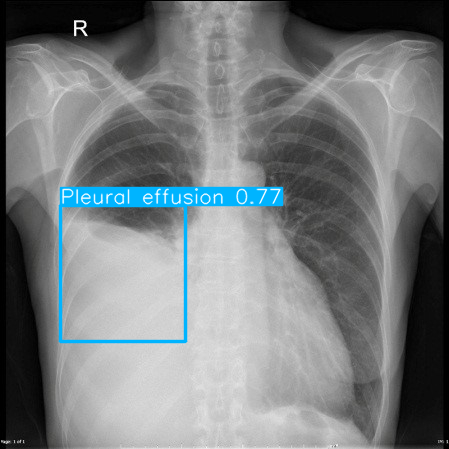

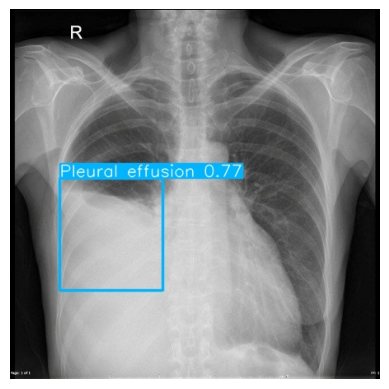

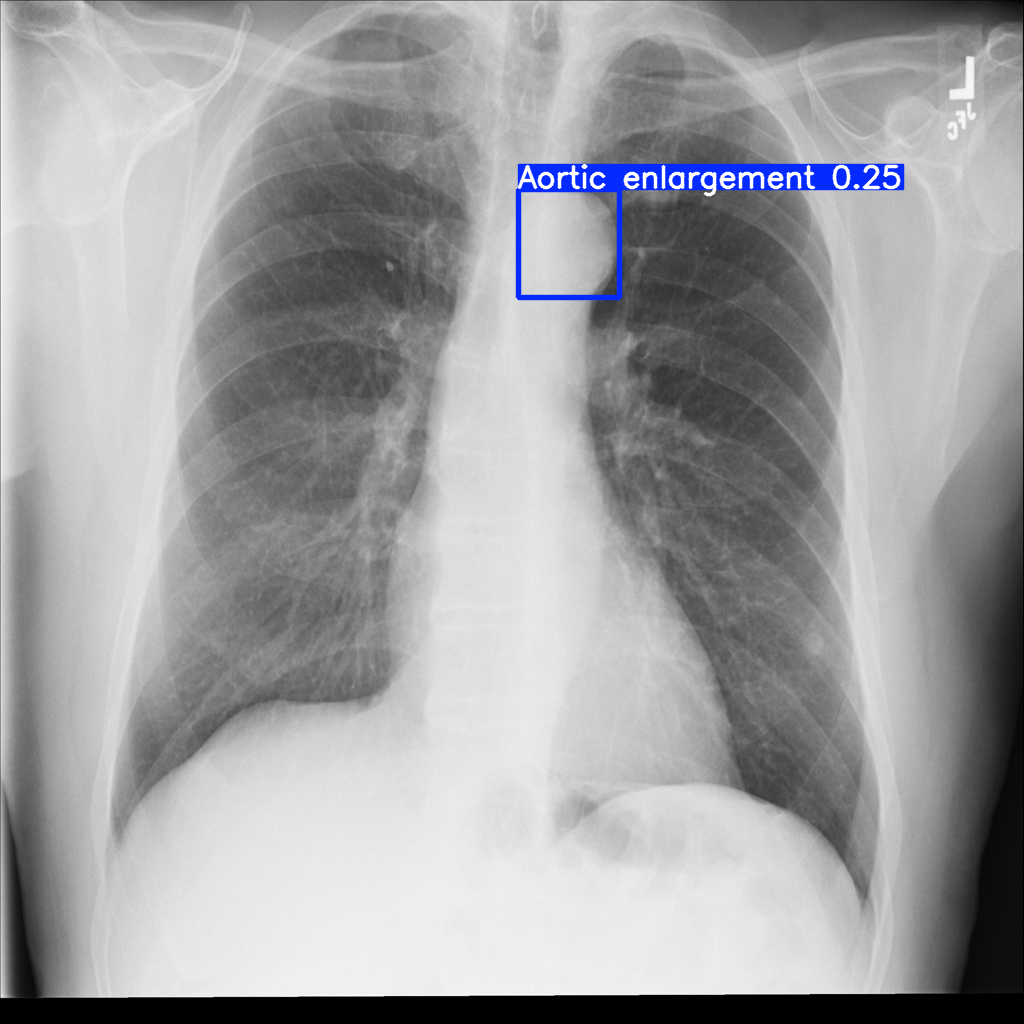

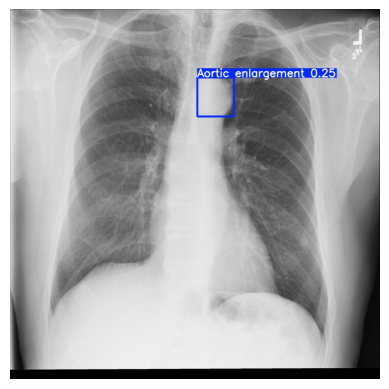

In [24]:
# Run batched inference on a list of images
results = test_model(["/kaggle/input/testmodeltrandich/trandich.jpg", "/kaggle/input/testmodel/00000021_001.png"])  # return a list of Results objects

from PIL import Image
import matplotlib.pyplot as plt

for idx, result in enumerate(results):
    result.show()  # Hiển thị kết quả trong notebook
    result.save(filename=f"result-{idx}.jpg")  # Lưu kết quả
    img = Image.open(f"result-{idx}.jpg")
    plt.imshow(img)
    plt.axis('off')
    plt.show()
